In this problem set, we'll do both unsupervised and supervised learning on text.

Similar to PS1, you're free to execute the notebook in your personal environment, but I would strongly recommend using Google Colab. You can upload this notebook to Google colab by following the steps below.

1. Open [colab.research.google.com](colab.research.google.com)
2. Click on the upload tab
3. Upload the `.ipynb` file by choosing the right file from your local disk


**Submission instructions**

1. When you're ready to submit, you'll save the notebook as QTM340-PS2-Firstname-Lastname.ipynb; for example, if your name is Harry Potter, save the file as `QTM340-PS2-Harry-Potter.ipynb`. This can be done in Google colab by editing the filename and then following File --> Download --> .ipynb

2. Upload this file on canvas.

In this problem set, you'll learn to:

(a) Use `gensim` to find topics

(b) Use scikit-learn to train multiple classifiers

(c) Calculate CI and test hypothesis

We'll do all of this on a collection of movie plot summaries that are extracted from Wikipedia courtesy of this [paper from Bamman et. al.](http://www.cs.cmu.edu/~dbamman/pubs/pdf/bamman+oconnor+smith.acl13.pdf).

In [ ]:
!wget http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz
!tar -xzvf MovieSummaries.tar.gz

--2023-11-03 00:40:39--  http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48002242 (46M) [application/x-gzip]
Saving to: ‘MovieSummaries.tar.gz’

MovieSummaries.tar. 100%[===================>]  45.78M  4.47MB/s    in 11s     

2023-11-03 00:40:50 (4.24 MB/s) - ‘MovieSummaries.tar.gz’ saved [48002242/48002242]

MovieSummaries/
MovieSummaries/tvtropes.clusters.txt
MovieSummaries/name.clusters.txt
MovieSummaries/plot_summaries.txt
MovieSummaries/README.txt
MovieSummaries/movie.metadata.tsv
MovieSummaries/character.metadata.tsv


You'll find a `MovieSummaries` directory which contains many files. We're interested in the `README.txt`, `plot_summaries.txt`, and `movie.metadata.txt`.

Let's print the `README.txt` file.

In [ ]:
!cat MovieSummaries/README.txt

This README describes data in the CMU Movie Summary Corpus, a collection of 42,306 movie plot summaries and metadata at both the movie level (including box office revenues, genre and date of release) and character level (including gender and estimated age).  This data supports work in the following paper:

David Bamman, Brendan O'Connor and Noah Smith, "Learning Latent Personas of Film Characters," in: Proceedings of the Annual Meeting of the Association for Computational Linguistics (ACL 2013), Sofia, Bulgaria, August 2013.

All data is released under a Creative Commons Attribution-ShareAlike License. For questions or comments, please contact David Bamman (dbamman@cs.cmu.edu).

###
#
# DATA
#
###

1. plot_summaries.txt.gz [29 M] 

Plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia.  Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary.


2. corenlp_plot_summaries.tar.gz [628 M, sep

The dataset directory contains wikipedia plot summaries for 42306 movies. There is also metadata for 81741 movies. For this assignment, we're interested in the genre of a movie, its wiki id, its release date, and its plot summary

In [ ]:
import pandas as pd
import gensim
from tqdm import tqdm
import numpy as np
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
tqdm.pandas()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Let's read the entire dataset as a pandas dataframe.

In [ ]:
# Read the plot summaries into a dataframe
df = pd.read_csv ('MovieSummaries/plot_summaries.txt', sep='\t', names=['wiki_id', 'summary'])

# Map the wikiid to a number and vice versa
wikiid2rownum = {id: i for i, id in enumerate (df.wiki_id.values)}
rownum2wikiid = {i: id for i, id in enumerate (df.wiki_id.values)}

# Read the metadata about the movies into a dataframe
metadata = pd.read_csv ("MovieSummaries/movie.metadata.tsv", sep='\t', names=["wiki_id",
                                                                              "freebase_id",
                                                                              "name",
                                                                              "release_date",
                                                                              "revenue",
                                                                              "runtime",
                                                                              "languages",
                                                                              "countries",
                                                                              "genres"])

## 1. Topic modeling [2 points]

We'll first try to do some exploratory analysis based on topic modeling. Particularly, we're interested in finding

- the topics in this collection
- the correlation of the topics
- the prevalence of topics over time

To do so, first we'll use the `nltk` library to tokenize the plot summaries. We could have also used `spacy` but it takes too much time.

We'll lower case the summaries, remove all the stop words, and only consider the alphabetic characters. The following code takes 2-3 minutes to run on google colab

In [ ]:
def tokenize_summaries (summary):
  stop = set(stopwords.words ('english'))
  tokens = nltk.word_tokenize(summary)
  tokens = [token.lower () for token in tokens if token.isalpha() and token not in stop]
  return tokens

df["tokens"] = df["summary"].progress_apply (lambda x: tokenize_summaries (x))

100%|██████████| 42303/42303 [02:04<00:00, 341.14it/s]


Let's create a dictionary for the corpus. We can do this by calling gensim's `Dictionary` object and passing the tokenized corpus. We'll also apply some light filters to trim the vocabulary to do topic modeling.

In [8]:
# Construct a dictionary of words from the corpus
dictionary = gensim.corpora.Dictionary(df['tokens'])
print (f"Before filtering: {len (dictionary)}")

# Filter the dictionary to meet frequency thresholds
dictionary.filter_extremes(no_below=10,
                           no_above=0.5,
                           keep_n=10000)
print (f"After filtering: {len (dictionary)}")

Before filtering: 134369
After filtering: 10000


By creating a dictionary in gensim, you map every token to an id, allowing you to convert a stream of tokens to a stream of ids. You can access these ids using `token2id` property that gets set. To run the LDA topic model, we'll have to transform the documents

In [9]:
# The map of wordids back the words
id2token = {id: token for token, id in dictionary.token2id.items()}

# Construction of the corpus in the format that gensim expects
corpus = [dictionary.doc2bow(doc) for doc in df['tokens']]

**Your turn!** Run LDA model for the above corpus to get 10 topics. [0.5 points]

You'll want to use `LdaMulticore` model and set the number of passes or sweeps over the data to 5 and number of iterations to 50.

**Note:** This may take a few minutes.

In [14]:
num_topics = 10
lda = gensim.models.LdaMulticore(corpus=corpus,
                                  id2word=id2token,
                                  num_topics=num_topics,
                                  passes=5,
                                  iterations=50)


In [15]:
# For the code below to run, your topic model should be in variable named lda

topics = lda.show_topics(num_topics=10, num_words=10, log=True, formatted=False)

# We'll print the top words associated with each topic
for topic_num, topic_words in topics:
  topic_rep = " ".join ([f"{w}({p:.4f})" for w,p in topic_words])
  print (f"Topic {topic_num}: {topic_rep}")

Topic 0: joe(0.0156) jimmy(0.0116) band(0.0106) sarah(0.0096) johnny(0.0085) katie(0.0080) party(0.0073) jane(0.0070) eddie(0.0070) steve(0.0069)
Topic 1: one(0.0051) ship(0.0050) war(0.0047) group(0.0046) men(0.0045) back(0.0045) they(0.0044) escape(0.0043) two(0.0043) he(0.0041)
Topic 2: he(0.0103) house(0.0074) tells(0.0069) back(0.0067) one(0.0067) car(0.0066) man(0.0065) room(0.0064) she(0.0062) find(0.0058)
Topic 3: police(0.0103) jack(0.0081) he(0.0060) money(0.0054) prison(0.0048) frank(0.0047) new(0.0046) murder(0.0045) case(0.0042) agent(0.0038)
Topic 4: she(0.0093) mother(0.0073) he(0.0073) love(0.0068) father(0.0064) home(0.0056) family(0.0053) life(0.0053) one(0.0052) when(0.0051)
Topic 5: film(0.0192) story(0.0070) life(0.0068) young(0.0063) in(0.0062) one(0.0061) world(0.0057) king(0.0052) people(0.0048) man(0.0047)
Topic 6: school(0.0279) charlie(0.0132) game(0.0110) team(0.0097) alex(0.0093) mike(0.0089) students(0.0085) ben(0.0080) max(0.0076) high(0.0072)
Topic 7: to

**Sanity check**: I found one topic which seemed to be about war and army, etc


**Your turn!** Now calculate the following distributions as numpy matrices[0.5 points]

(a) For every document, get the mixture of topics. We can do this by calling the `get_document_topics` of the lda model method on the entire corpus.

(b) For every topic, get the distribution over words. We can do this by calling the `get_topic_terms` of the lda model on the entire vocabulary.

You'll implement two functions below to calculate these.



In [16]:
def get_topic_mixture (corpus, lda_model):
  """ Get mixture of topics from the corpus.

  :params:
  :corpus (list): The transformed corpus where every document is a list
  :lda_model (gensim.models.ldamulticore.LdaMulticore): The gensim model

  :returns:
  topic_mixture (np.array): The corpus is represented as a numpy matrix, where
                            each row is a document and the columns correspond
                            to topics.

                            Size = number of documents x number of topics

  """
  num_docs = len(corpus)
  topic_mixture = np.zeros((num_docs, num_topics))

  for i, doc in enumerate(corpus):
    doc_topics = lda_model.get_document_topics(doc, minimum_probability=0)

    for topic_id, prob in doc_topics:
      topic_mixture[i, topic_id] = prob

  return topic_mixture


def get_word_dist (lda_model):
  """ Get the probability distribution of words for all the topics.

  :params:
  :lda_model (gensim.models.ldamulticore.LdaMulticore): The gensim model

  :returns:
  word_dist (np.array): The topics are represented as a numpy matrix, where
                        each row is a topic and the columns correspond to the
                        words.

                        Size = number of topics x number of words
  """
  # Your code here
  vocabulary_size = len(lda.id2word)
  word_dist = np.zeros((num_topics, vocabulary_size))

  for topic_id in range(num_topics):
        topic_terms = lda_model.get_topic_terms(topic_id, topn=vocabulary_size)
        for word_id, prob in topic_terms:
            word_dist[topic_id, word_id] = prob


  return word_dist

Now, let's call these functions to get the distributions.

In [17]:
topic_mix = get_topic_mixture (corpus, lda)
word_dist = get_word_dist (lda)

In fact, we'll just add all the topic probabilities to the dataframe

In [18]:
for i in range (lda.num_topics):
  df[f'topic_{i}'] = topic_mix[:,i]

You can see that we have added additional columns to the dataframe to have the distribution of topics for every movie.

In [19]:
df.head(7)

,wiki_id,summary,tokens,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","[shlykov, taxi, driver, lyosha, saxophonist, d...",0.011120,0.011119,0.288934,0.011119,0.622107,0.011122,0.011120,0.011119,0.011120,0.011119
1,31186339,The nation of Panem consists of a wealthy Capi...,"[the, nation, panem, consists, wealthy, capito...",0.000295,0.244372,0.241556,0.080722,0.068229,0.178712,0.008861,0.000295,0.070874,0.106084
2,20663735,Poovalli Induchoodan is sentenced for six yea...,"[poovalli, induchoodan, sentenced, six, years,...",0.000472,0.000472,0.000472,0.289681,0.000472,0.061620,0.000472,0.000472,0.645392,0.000472
3,2231378,"The Lemon Drop Kid , a New York City swindler,...","[the, lemon, drop, kid, new, york, city, swind...",0.000250,0.000250,0.077156,0.321231,0.220866,0.000250,0.000250,0.299791,0.000250,0.079707
4,595909,Seventh-day Adventist Church pastor Michael Ch...,"[adventist, church, pastor, michael, chamberla...",0.000589,0.000589,0.278198,0.313662,0.146118,0.224911,0.000589,0.000589,0.000589,0.034164
5,5272176,The president is on his way to give a speech. ...,"[the, president, way, give, speech, while, tra...",0.128750,0.000532,0.478746,0.309156,0.000532,0.000532,0.025526,0.055161,0.000532,0.000532
6,1952976,"{{plot}} The film opens in 1974, as a young gi...","[plot, the, film, opens, young, girl, dahlia, ...",0.056838,0.035302,0.503416,0.000288,0.298671,0.000288,0.104334,0.000288,0.000288,0.000288


**Your turn!** Now let's find the correlation between the topics. We can do this by calculating the cosine distance between each pair of topics using the code from problem set 1 or you can use [this scikit-learn method](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html). Notice that every topic is a vectory of probabilities over words.

Give 3 topic pairs with the strongest correlation and 3 topic pairs with the weakest correlation? [0.5 points]

In [20]:
# Your code here to calculate the cosine distances
from sklearn.metrics.pairwise import cosine_distances

tops = df.iloc[:,3:]
distance = cosine_distances(tops.T)

unique_distances = distance[np.triu_indices(distance.shape[0], k=1)]
sorted_distances = np.sort(unique_distances)

highest_three = sorted_distances[-3:][::-1]
lowest_three = sorted_distances[:3]
print(f"Highest three cosine distances: {highest_three}")
print(f"Lowest three cosine distances: {lowest_three}")

Highest three cosine distances: [0.93687812 0.92098632 0.91822225]
Lowest three cosine distances: [0.72112445 0.74413028 0.74635489]


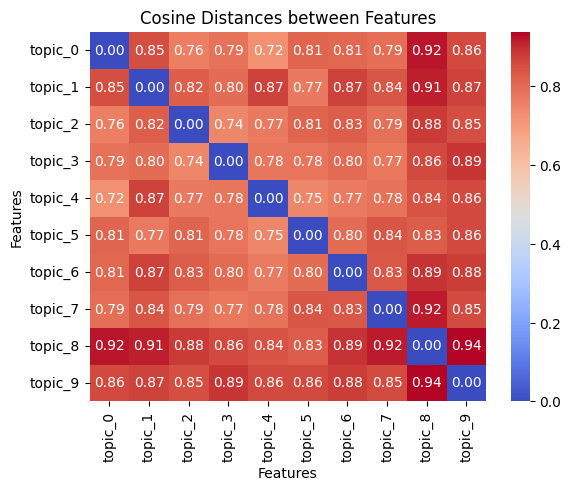

In [21]:
import seaborn as sns
distance_df = pd.DataFrame(distance,
                          index=df.columns[3:],
                          columns=df.columns[3:])

# Create the heatmap
sns.heatmap(distance_df, annot=True, fmt=".2f", cmap='coolwarm')

# Set titles and labels
plt.title('Cosine Distances between Features')
plt.xlabel('Features')
plt.ylabel('Features')

# Show the plot
plt.show()


**Your turn!** Find the distribution of topics over time. Following are the steps that you want to follow, which you'll implement in each cell below [0.5 points]

We have the release date for each movie in the `release_date` column of the metadata frame.  We want to first filter the dataframe to exclude any missing values (NaN)

In [26]:
# Step 1 filter the metadata (Your code below)
metadata_filtered = metadata.dropna()

- Next, you'll create two new columns for the year of release and decade of the release. Note that the release date is either the year directly or the full date string.

In [52]:
def extract_year (pub_date):
  """ Extract the year from the publication date string
  :params:
  pub_date (str): The publication date as a string

  :returns:
  year (int): The release year of the movie
  """
  if isinstance(pub_date, str) and len(pub_date) >= 4:
      pub_date = pub_date.strip()
      year = pub_date[:4]
      if year.isdigit():
        return int(year)


def get_decade (year):
  """ Convert the year into the decade i.e 2017 --> 2010; 1992 -->1990

  :params:
  year (int): The year of release

  :returns:
  decade (int): The decade of the release
  """

  if year:
        return (year // 10) * 10

new_metadata = metadata_filtered

# Step 2 add the two columns
new_metadata["year"] = new_metadata["release_date"].apply (lambda x: extract_year (x))
new_metadata["decade"] = new_metadata["year"].apply (lambda x: get_decade (x))

<ipython-input-52-f4b2a519c04b>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_metadata["year"] = new_metadata["release_date"].apply (lambda x: extract_year (x))
<ipython-input-52-f4b2a519c04b>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_metadata["decade"] = new_metadata["year"].apply (lambda x: get_decade (x))


- Now join the dataframes that contain the text and the topics with the metadata by matching the field `wiki_id` from both the dataframes.

In [28]:
# Step 3 Join the two dataframes on the common column (Your code below)
merged_dataframe = pd.merge(df, new_metadata,
                            how='inner',
                            on='wiki_id')

merged_dataframe


,wiki_id,summary,tokens,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,freebase_id,name,release_date,revenue,runtime,languages,countries,genres,year,decade
0,31186339,The nation of Panem consists of a wealthy Capi...,"[the, nation, panem, consists, wealthy, capito...",0.000295,0.244372,0.241556,0.080722,0.068229,0.178712,0.008861,...,/m/0gkz15s,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...",2012,2010
1,2231378,"The Lemon Drop Kid , a New York City swindler,...","[the, lemon, drop, kid, new, york, city, swind...",0.000250,0.000250,0.077156,0.321231,0.220866,0.000250,0.000250,...,/m/06xtz3,The Lemon Drop Kid,1951-03-08,2300000.0,91.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""...",1951,1950
2,595909,Seventh-day Adventist Church pastor Michael Ch...,"[adventist, church, pastor, michael, chamberla...",0.000589,0.000589,0.278198,0.313662,0.146118,0.224911,0.000589,...,/m/02tqm5,A Cry in the Dark,1988-11-03,6908797.0,121.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,1980
3,1952976,"{{plot}} The film opens in 1974, as a young gi...","[plot, the, film, opens, young, girl, dahlia, ...",0.056838,0.035302,0.503416,0.000288,0.298671,0.000288,0.104334,...,/m/068jvg,Dark Water,2005-06-27,49483352.0,105.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/07s9rl0"": ""Drama...",2005,2000
4,24225279,"The story begins with Hannah, a young Jewish t...","[the, story, begins, hannah, young, jewish, te...",0.000343,0.000343,0.059487,0.061347,0.293568,0.101172,0.289687,...,/m/07kbs3s,Sing,1989,2260616.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/02b5_l"": ""Teen""}",1989,1980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7458,13348400,Jennie Lee is the lead singer of an all-girl ...,"[jennie, lee, lead, singer, rock, band, named,...",0.595174,0.000308,0.000308,0.037434,0.266309,0.000308,0.033118,...,/m/03c2h8h,Satisfaction,1988-02-12,8253123.0,92.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/01z4y"": ""Comedy""}",1988,1980
7459,24005728,Jo Pil-seong is an idle detective who spends h...,"[jo, idle, detective, spends, time, scratching...",0.000378,0.173320,0.476826,0.091504,0.000378,0.000378,0.114903,...,/m/07k86_5,Running Turtle,2009-06-11,16823955.0,117.0,{},"{""/m/06qd3"": ""South Korea""}","{""/m/01jfsb"": ""Thriller"", ""/m/0cq22f9"": ""Actio...",2009,2000
7460,277160,"Virginia ""Gin"" Baker is an investigator for W...","[virginia, gin, baker, investigator, waverly, ...",0.000470,0.082775,0.309722,0.300939,0.000470,0.000470,0.000470,...,/m/01pgrh,Entrapment,1999-04-30,212404396.0,113.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/03btsm8"": ""Action/Adventure"", ""/m/02wtdps...",1999,1990
7461,677389,Dr. Sullivan Travis is a wealthy Dallas gyne...,"[sullivan, travis, wealthy, dallas, gynecologi...",0.001820,0.001820,0.001820,0.148702,0.748145,0.001820,0.001820,...,/m/0323y3,Dr. T & the Women,2000-09-12,22844291.0,118.0,"{""/m/02h40lc"": ""English Language"", ""/m/04306rv...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...",2000,2000


- Finally, calculate the average probability per decade from 1900 to 2010. You may want to use pandas `groupby` function from the pandas library

In [29]:
decades = [1900,
           1910,
           1920,
           1930,
           1940,
           1950,
           1960,
           1970,
           1980,
           1990,
           2000,
           2010]

# Step 4: calculate the average probability by grouping (Your code below)

decade_dataframe = merged_dataframe[(merged_dataframe['decade'] >= 1900) & (merged_dataframe['decade'] <= 2010)]


grouped = decade_dataframe.groupby('decade').mean()

grouped.head()


<ipython-input-29-10417d9306d1>:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = decade_dataframe.groupby('decade').mean()


,wiki_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,revenue,runtime,year
decade,,,,,,,,,,,,,,
1910,3.333000e+03,0.000238,0.217754,0.159108,0.022213,0.000239,0.218012,0.068327,0.213470,0.100401,0.000239,5.000000e+07,190.000000,1915.000000
1920,7.378115e+06,0.037283,0.058750,0.072378,0.028989,0.346452,0.143415,0.028298,0.127824,0.074096,0.082513,2.727346e+06,110.409091,1925.636364
1930,7.711633e+06,0.044671,0.101531,0.053143,0.151703,0.369875,0.089004,0.027612,0.078296,0.039964,0.044201,8.421825e+06,94.358333,1935.183333
1940,6.524586e+06,0.048080,0.145978,0.054457,0.106623,0.326491,0.131913,0.031254,0.070170,0.040083,0.044952,7.696274e+06,103.838384,1944.434343
1950,9.710667e+06,0.044642,0.169730,0.058229,0.131494,0.266635,0.102542,0.034954,0.110999,0.040434,0.040341,4.297896e+06,100.792746,1953.808290


<Axes: xlabel='decade'>

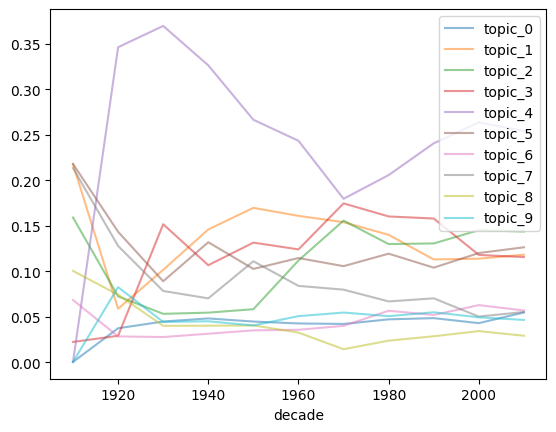

In [32]:
per_decade_plot = grouped.reset_index()
per_decade_plot.plot(x="decade", y=[f"topic_{i}" for i in range (10)], alpha=0.5)

**Sanity check!** I found the "war" topic to peak in the 1910's then fall during the great depression and rise again in the 50's after which it has remained quite steady. I'm not sure if it matches any hypothesis but it's interesting nonetheless!

## 2. Prediction [4 points]

In this section, we'll develop multiple regression models to predict the box office revenue of a movie. We'll start by first filtering the dataframe to contain only those movies which don't have any missing data.

In [33]:
regression_df = merged_dataframe.dropna() # remove all the rows that contain any missing values
regression_df = regression_df.query ("decade in @decades")

Once you have the `regression_df` dataframe, we'll create another column called `tokenized_text` as follows

In [34]:
regression_df["tokenized_text"] = regression_df["tokens"].apply (lambda x:" ".join (x))

Let's see what the regression dataframe looks like

In [35]:
regression_df.head (5)

,wiki_id,summary,tokens,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,name,release_date,revenue,runtime,languages,countries,genres,year,decade,tokenized_text
0,31186339,The nation of Panem consists of a wealthy Capi...,"[the, nation, panem, consists, wealthy, capito...",0.000295,0.244372,0.241556,0.080722,0.068229,0.178712,0.008861,...,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...",2012,2010,the nation panem consists wealthy capitol twel...
1,2231378,"The Lemon Drop Kid , a New York City swindler,...","[the, lemon, drop, kid, new, york, city, swind...",0.000250,0.000250,0.077156,0.321231,0.220866,0.000250,0.000250,...,The Lemon Drop Kid,1951-03-08,2300000.0,91.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""...",1951,1950,the lemon drop kid new york city swindler ille...
2,595909,Seventh-day Adventist Church pastor Michael Ch...,"[adventist, church, pastor, michael, chamberla...",0.000589,0.000589,0.278198,0.313662,0.146118,0.224911,0.000589,...,A Cry in the Dark,1988-11-03,6908797.0,121.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,1980,adventist church pastor michael chamberlain wi...
3,1952976,"{{plot}} The film opens in 1974, as a young gi...","[plot, the, film, opens, young, girl, dahlia, ...",0.056838,0.035302,0.503416,0.000288,0.298671,0.000288,0.104334,...,Dark Water,2005-06-27,49483352.0,105.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/07s9rl0"": ""Drama...",2005,2000,plot the film opens young girl dahlia stands o...
4,24225279,"The story begins with Hannah, a young Jewish t...","[the, story, begins, hannah, young, jewish, te...",0.000343,0.000343,0.059487,0.061347,0.293568,0.101172,0.289687,...,Sing,1989,2260616.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/02b5_l"": ""Teen""}",1989,1980,the story begins hannah young jewish teen comp...


In [59]:
regression_df.shape

(7462, 24)

The code above simply joins the individual tokens from the plot summary in any movie into a string in which the tokens are separated by a whitespace

Next, we'll split the movies into a train and a test set as follows

In [57]:
train_wikiids, test_wikiids = train_test_split(regression_df.wiki_id,
                                               test_size=0.2,
                                               random_state=42)

We can create an array for our dependent variable in both the train and test sets

In [58]:
y_train = regression_df.query ('wiki_id in @train_wikiids').revenue.values
y_test = regression_df.query ('wiki_id in @test_wikiids').revenue.values

Finally, you'll need to use a tfidf vectorizer for some of the models which can be done in the following

In [38]:
vectorizer = TfidfVectorizer (sublinear_tf=True,
                              max_features=500,
                              max_df=0.5,
                              min_df=5)

We'll develop nested regression models from the following feature sets:

1. **Length of the movie (M)**: This feature is a scalar value that can be obtained directly by accessing the `runtime` field in the dataframe.

2. **Genres (G)**: Every movie is associated with a dictionary of genres, which can be accessed using the `genres` column in the dataframe. The key in this dictionary is a freebase id and the value is a genre name in plain english. To use genres as features, we'll need to convert the plain english names to a vector. Fortunately, we know how to do this tranformation -- by treating the different genres for a movie as a bag-of-genres vector. Thus, if there are K unique genres in total, the genres feature vector is of size K and the dimensions are either 0 or 1 indicating the presence or absence of a genre.

3. **Plot summaries (S)**: Every movie also contains a summary. We'll featurize the summary by creating a tfidf vector for each summary. The vocabulary size should be capped at 500.

4. **Topics (T)**: Every movie can be represented by a topic mixtures vector which we obtained in the previous section.

**Your turn!** You'll fill the following table for the different nested models with the root mean squared error between the predicted revenue for each model and the actual revenue. State the model that performs best [2 points]


|Models|RMSE|
|------|----|
|M||
|G||
|S||
|T||
|M+G||
|G+S||
|S+T||
|M+G+S||
|G+S+T||
|M+G+S+T||

**Notes:**

- Our regression model will use the features to predict the log of the revenue although the RMSE will be calculated by comparing the actual revenues.

- [RMSE](https://statisticsbyjim.com/regression/root-mean-square-error-rmse/) is a measure to evaluate the performance of a model by comparing the model predictions to the ground truth value. You can calculate RMSE by using [this function from sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) setting the `squared` argument to `False`. A smaller RMSE value suggest a more accurate model

- The addition of models here means that the combined model has all the features from the individual models. For example, an M+D model means the features from the M model and the D model are concatenated.

- You may want to use [numpy's hstack](https://numpy.org/doc/stable/reference/generated/numpy.hstack.html) method to concatenate the feature vectors

- You may also want to use the tfidf vectorizer we created earlier to get the tfidf features for each document [See this](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).



To build the above models, we'll implement the following functions.


**Your turn!** First, a function to train and test a regression model for the different features. By passing different feature matrices, we can reuse this function to train and test all our regression models [0.5 points]

In [192]:
def train_and_test (X_train, y_train, X_test, y_test):
  """ Trains a linear regression model, makes predictions with
  the trained model, and calculates the root mean squared error
  between the predicted values and the true values

  NOTE: Instead of regressing against the revenue, it might be better to predict
  the log of the revenue

  :params:
  :X_train (np.array): The predictors in the regression problem for the training data
  :y_train (np.array): The dependent variable in the regression problem for the training data
  :X_test (np.array): The predictors in the regression problem for the testing data
  :y_test (np.array): The dependent variable in the regression problem for the testing data

  :returns: the following triple as a tuple
  :lr (LinearRegression): The linear regression model obtained from sklearn
  :yhat (np.array): The array of predictions from the regression model on test data
  :err (float): The RMSE error between predicted values and test data outputs
  """

  lr, yhat, err = None, None, None
  # Your code below

  lr = LinearRegression()

  lr.fit(X_train, y_train)

  yhat = lr.predict(X_test)

  err = mean_squared_error(np.exp(y_test), np.exp(yhat), squared= False) # calculate the loss based on actual value

  return lr, np.exp(yhat), err

**Your turn!** Next, we'll write a function that transforms the genres to their features [0.5 points]

**Hint!** Use sklearn's countvectorizer to extract the features

In [193]:
import numpy as np
from collections import Counter

def make_genre_features(genres):
    """ Convert the plain English names of the genres from a dictionary
        to a bag of words vector.

    :params:
    :genres (np.array): Every item in the array is a string representation of a
                        dictionary, which lists all the genres for the movie.

    :returns: pair of objects as tuple
    genre_mat (np.array): A binary matrix of size = num_movies X num_genres;
                          1 represents whether the movie corresponding to the row
                          is of the genre corresponding to the column

    genre2index (dict): A dictionary that maps the genre name to column number
    """
    genre_counter = Counter()
    for genre_str in genres:
        genre_dict = eval(genre_str)
        genre_counter.update(genre_dict.values())


    top_genres = [genre for genre, count in genre_counter.most_common(20)]

    genre2index = {genre: i for i, genre in enumerate(top_genres)}


    num_movies = len(genres)
    num_genres = len(top_genres)
    genre_mat = np.zeros((num_movies, num_genres))


    for row, genre_str in enumerate(genres):
        genre_dict = eval(genre_str)
        for genre in genre_dict.values():
            if genre in genre2index:
                genre_mat[row][genre2index[genre]] = 1

    return genre_mat, genre2index

**Your turn!** We'll also write a utility function that helps preserve the train and test indices from the overall sequence of wikiids [0.5 points]


For example:
Suppose the sequence of wikiids was originally [1234, 5632, 756, 8354, 18792]. When we split into a train and test set, the train sequence turned out to be [8354, 1234, 756] and the test sequence as [18792, 5632]. Our function should give us an array of train indices as [3, 0, 2] and test indices as [4, 1].

In [194]:
def train_and_test_indices (all_ids, train_ids, test_ids):
  """ Find the indices of elements from train_ids and test_ids in the all_ids.

  e.g. all_ids = [1234, 5632, 756, 8354, 18792],
       train_ids = [8354, 1234, 756],
       test_ids = [18792, 5632]

       The output should be two lists:
       train_indices = [3,0,2],
       test_indices = [4,1]

  :params:
  :all_ids (np.array): All the wikipedia ids
  :train_ids (np.array): All the wikipedia ids part of the training set
  :test_ids (np.array): All the wikipedia ids part of the test set

  :returns: the following pair as a tuple
  :train_indices (np.array): The train indices for all the train ids
  :test_indices (np.array): The test indices for all the test ids
  """


  train_indices, test_indices = [], []
  # Your code below
  all_ids = all_ids.tolist()
  train_ids, test_ids = train_ids, test_ids.tolist()
  for train_id in train_ids:
    train_indices.append(all_ids.index(train_id))

  for test_id in test_ids:
      test_indices.append(all_ids.index(test_id))

  return train_indices, test_indices


Now let me show you how you can calculate the RMSE with the above functions for one such model -- predicting the revenue by the runtime of the movie. Long movies may not produce great box-office revenue but this predictor is unlikely to be great because there isn't much variability in the runtime of a movie.

In [200]:
# Predict movie revenue using movie runtime
X_train_runtime = np.reshape(regression_df.query ('wiki_id in @train_wikiids').runtime.values, (-1, 1))
X_test_runtime = np.reshape(regression_df.query ('wiki_id in @test_wikiids').runtime.values, (-1, 1))
lr_m, _, err_m = train_and_test (X_train_runtime, np.log(y_train), X_test_runtime,np.log(y_test))
print (f"RMSE: {err_m:.2f}")

RMSE: 128530237.60


**Your turn!** Fill all the cells below to get the RMSE for individual models [0.5 points]

In [195]:
# Predict the movie revenue using the genres of release.
# This is where you should call make_genre_features and train_test_indices

X_train_genres = None
X_test_genres = None

# Your code below to calculate the feature matrices
X_train_genre_id= regression_df.query ('wiki_id in @train_wikiids').wiki_id.values
X_test_genre_id = regression_df.query ('wiki_id in @test_wikiids').wiki_id.values


In [196]:
train_indices, test_indices = train_and_test_indices(regression_df['wiki_id'], X_train_genre_id, X_test_genre_id)

In [197]:
X_train_genres, mapping = make_genre_features(merged_dataframe.iloc[train_indices]['genres'])
test_genre = merged_dataframe.iloc[test_indices]['genres']
test_genre = test_genre.tolist()

In [198]:
X_test_genres = np.zeros((len(test_genre), len(mapping)))
for index, genres in enumerate(test_genre):
  genres = eval(genres)
  for genre in genres.values():
    if genre in mapping.keys():
      X_test_genres[index][mapping[genre]] = 1

In [199]:
lr_g, _, err_g = train_and_test (X_train_genres, np.log(y_train), X_test_genres, np.log(y_test))
print (f"RMSE: {err_g:.2f}")

RMSE: 118050525.09


In [209]:
# Predict the movie revenue using the tfidf vectors of text in plot summaries

X_train_summary = None
X_test_summary = None

# Your code below to calculate the feature matrices
vectorizer.fit(merged_dataframe.iloc[train_indices]['summary'])
X_train_summary = vectorizer.transform(merged_dataframe.iloc[train_indices]['summary'])
X_test_summary = vectorizer.transform(merged_dataframe.iloc[test_indices]['summary'])



In [203]:
# Train and evaluate
lr_s, _, err_s = train_and_test (X_train_summary.toarray(), np.log(y_train), X_test_summary.toarray(), np.log(y_test))
print (f"RMSE: {err_s:.2f}")

RMSE: 116480286.51


In [205]:
# Predict the movie revenue using the topic vectors for each movie

# Your code below to calculate the feature matrices
X_train_topics = merged_dataframe.iloc[train_indices, 3:13]
X_test_topics = merged_dataframe.iloc[test_indices, 3:13]

# Train and evaluate
lr_t, _, err_t = train_and_test (X_train_topics, np.log(y_train), X_test_topics, np.log(y_test))
print (f"RMSE: {err_t:.2f}")

RMSE: 119142539.93


In [207]:
# Predict the movie revenue using movie length and the genre features
# Note: When creating a combined feature matrix, you may want to convert the
# individual feature matrices as numpy arrays

X_train_runtime = np.reshape(regression_df.query ('wiki_id in @train_wikiids').runtime.values, (-1, 1))
X_test_runtime = np.reshape(regression_df.query ('wiki_id in @test_wikiids').runtime.values, (-1, 1))

X_train_runtime_genres = np.hstack([X_train_runtime,
                                    X_train_genres])
X_test_runtime_genres = np.hstack([X_test_runtime,
                                   X_test_genres])
# Train and evaluate
lr_m_g, _, err_m_g = train_and_test (X_train_runtime_genres,
                                     np.log(y_train),
                                     X_test_runtime_genres,
                                     np.log(y_test))
print (f"RMSE: {err_m_g:.2f}")

RMSE: 151698191.86


In [241]:
# Predict the movie revenue using movie length and the decade features
# Note: When creating a combined feature matrix, you may want to convert the
# individual feature matrices as numpy arrays
import scipy.sparse
from scipy.sparse import hstack

X_train_genres_summary = hstack([X_train_genres, X_train_summary])
X_test_genres_summary = hstack([X_test_genres, X_test_summary])


# Train and evaluate
lr_g_s, _, err_g_s = train_and_test (scipy.sparse.csr_matrix (X_train_genres_summary),
                                     np.log(y_train),
                                     scipy.sparse.csr_matrix (X_test_genres_summary),
                                     np.log(y_test))
print (f"RMSE: {err_g_s:.2f}")


RMSE: 115889564.70


In [250]:
# Predict the movie revenue using movie length and the decade features
# Note: When creating a combined feature matrix, you may want to convert the
# individual feature matrices as numpy arrays
import scipy.sparse
from scipy.sparse import hstack

X_train_topics_sparse = scipy.sparse.csr_matrix(X_train_topics) if not scipy.sparse.issparse(X_train_topics) else X_train_topics
X_test_topics_sparse = scipy.sparse.csr_matrix(X_test_topics) if not scipy.sparse.issparse(X_test_topics) else X_test_topics

X_train_summary_topics = hstack([X_train_summary,
                                X_train_topics_sparse])
X_test_summary_topics = hstack([X_test_summary,
                                X_test_topics_sparse])

# Train and evaluate
lr_s_t, _, err_s_t = train_and_test (scipy.sparse.csr_matrix (X_train_summary_topics),
                                     np.log(y_train),
                                     scipy.sparse.csr_matrix (X_test_summary_topics),
                                     np.log(y_test))
print (f"RMSE: {err_s_t:.2f}")

RMSE: 116409816.22


In [251]:
# Predict the movie revenue using movie length, genre, and plot summaries
# Note: When creating a combined feature matrix, you may want to convert the
# individual feature matrices as numpy arrays
import scipy.sparse
from scipy.sparse import hstack, csr_matrix

X_train_runtime_sparse = csr_matrix(X_train_runtime)
X_test_runtime_sparse = csr_matrix(X_test_runtime)

X_train_runtime_genres_summary = hstack([X_train_runtime_sparse,
                                         X_train_genres,
                                         X_train_summary])

X_test_runtime_genres_summary = hstack([X_test_runtime_sparse,
                                        X_test_genres,
                                        X_test_summary])


# Train and evaluate
lr_m_g_s, _, err_m_g_s = train_and_test (scipy.sparse.csr_matrix (X_train_runtime_genres_summary),
                                     np.log(y_train),
                                     scipy.sparse.csr_matrix (X_test_runtime_genres_summary),
                                     np.log(y_test))
print (f"RMSE: {err_m_g_s:.2f}")

RMSE: 114762228.93


In [254]:
# Predict the movie revenue using genre, plot summaries, and topics
# Note: When creating a combined feature matrix, you may want to convert the
# individual feature matrices as numpy arrays
import scipy.sparse
from scipy.sparse import hstack, csr_matrix

X_train_topics_sparse = csr_matrix(X_train_topics)
X_test_topics_sparse = csr_matrix(X_test_topics)

X_train_genres_summary_topics = hstack([X_train_topics_sparse,
                                        X_train_genres,
                                        X_train_summary])

X_test_genres_summary_topics = hstack([X_test_topics_sparse,
                                       X_test_genres,
                                       X_test_summary])

# Train and evaluate
lr_g_s_t, _, err_g_s_t = train_and_test (scipy.sparse.csr_matrix (X_train_genres_summary_topics),
                                     np.log(y_train),
                                     scipy.sparse.csr_matrix (X_test_genres_summary_topics),
                                     np.log(y_test))
print (f"RMSE: {err_g_s_t:.2f}")

RMSE: 115952092.58


In [256]:
# Predict the movie revenue using all the features
# Note: When creating a combined feature matrix, you may want to convert the
# individual feature matrices as numpy arrays
import scipy.sparse
from scipy.sparse import hstack, csr_matrix

X_train_topics_sparse = csr_matrix(X_train_topics)
X_test_topics_sparse = csr_matrix(X_test_topics)
X_train_runtime_sparse = csr_matrix(X_train_runtime.reshape(-1, 1))
X_test_runtime_sparse = csr_matrix(X_test_runtime.reshape(-1, 1))

X_train_all = hstack([X_train_topics_sparse,
                      X_train_genres,
                      X_train_summary,
                      X_train_runtime_sparse])

X_test_all = hstack([X_test_topics_sparse,
                     X_test_genres,
                     X_test_summary,
                     X_test_runtime_sparse])

# Train and evaluate
lr_all, _, err_all= train_and_test (scipy.sparse.csr_matrix (X_train_all),
                                     np.log(y_train),
                                     scipy.sparse.csr_matrix (X_test_all),
                                     np.log(y_test))
print (f"RMSE: {err_all:.2f}")

RMSE: 114653540.69


## Extra credit [1 point]

Try to reduce the RMSE of the best-performing model. Potential ways to reduce RMSE:

- Include more topics
- Include more genres
- Perform non-linear regression

Try one of the above or your own idea to reduce RMSE

## Confidence intervals over coefficients [2 points]

Our regression model gives us the coefficients associated with the features. In this section, we'll obtain the confidence intervals of these coefficients using bootstrapping. To obtain the confidence intervals around any coefficient, we would need to train the model on different samples obtained by sampling with replacement and calculate the CI empirically.

**Your turn!** Write a function to calculate the coefficients of a linear regression model on some training data a given number of times [0.5 points]

In [232]:
def bootstrapped_regression (X_train, y_train, num_bootstraps=1000):
  """ Fit linear models on bootstrapped samples

  :params:
  X_train (np.array): The train feature matrix
  y_train (np.array): The train output values
  num_bootstraps (int): 100

  :returns:
  coeffs (list): The coeffcients for all the features for every boostrap sample
  """
  from sklearn.utils import resample

  coeffs = list ()

  for i in range(num_bootstraps):
    X_resampled, y_resampled = resample(X_train, y_train)

    model = LinearRegression().fit(X_resampled, y_resampled)

    coeffs.append(model.coef_)

  return coeffs

**Your turn!** Write a function to calculate the empirical confidence interval for a coefficient estimate [0.5 points]

In [233]:
def get_empirical_CI (values, lower=0.025, upper=.975):
  """ Calculate the empirical confidence interval from the given values

  :params:
  :values (np.array): Values of bootstrapped estimates
  :lower (float): The lower percentile (default:2.5)
  :upper (float): The upper percentile (default:97.5)

  :returns: pair as a tuple
  :lower_bound (float): The lower bound of the CI
  :upper_bound (float): The upper bound of the CI

  """
  values = np.sort(values)

  lower_bound = np.percentile(values, lower * 100)
  upper_bound = np.percentile(values, upper * 100)

  return lower_bound, upper_bound

**Your turn!** Calcualte the CI for coefficient estimates for the following

a. runtime [0.5 points]

b. genre corresponding to comedy [0.5 points]

What can you tell about the statistical significance of the estimate from the confidence interval for both the variables?

**Note:** Do 1000 bootstrapped intervals

In [236]:
coeffs = bootstrapped_regression (X_train_runtime, np.log(y_train), num_bootstraps=1000)
lb, ub = get_empirical_CI (np.array([item[0] for item in coeffs]))

print(lb, ub)

0.012677176869220732 0.0296108179379014


In [238]:
coeffs = bootstrapped_regression (X_train_genres, np.log(y_train), num_bootstraps=1000)
lb, ub = get_empirical_CI (np.array([item[mapping.get('Comedy')] for item in coeffs]))

print(lb, ub)

0.1807078067246378 0.4529206047268139
